In [2]:
from datetime import date
import snscrape.modules.twitter as sntwitter
import pandas as pd
import numpy as np
from textblob import TextBlob
from wordcloud import WordCloud
import re
import matplotlib.pyplot as plt
import seaborn as sns
#plt.style.use('fivethirtyeight')
import nltk
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
import spacy
#nlp = spacy.load("en_core_web_sm")

In [1]:
!pip install snscrape

In [2]:
!pip install textblob

In [3]:
!pip install wordcloud

In [4]:
!pip install spacy

## Q3) What is the sentiment of tweets around the China Covid19 Zero Policy and the probability of China reopening?

## We Check for the tweets that match with the phrases china, zerocovid and policy for the year 2022 from each month

In [19]:
word = 'china lockdown reopen'
mo = [i for i in range(1,13)]
str1 = [str('2022-' + str(i) + '-01') for i in range(1,13)]
str2 = [str('2022-' + str(i) + '-28') for i in range(1,13)]

## Scraping upto 100k tweets for each month

In [20]:
tweets_list = []
maxTweets = 100000
# Using TwitterSearchScraper to scrape data and append tweets to list
for i,j in zip(str1,str2):
    string1 = str(word + ' since:' + str(i) + ' until:' + str(j))
    #print(str('recession 2023' + ' since:' + i + ' until:' + j))
    for i,tweet in enumerate(sntwitter.TwitterSearchScraper(string1).get_items()):
        if i>maxTweets:
            break
        tweets_list.append([tweet.date, tweet.id, tweet.content])
    print("Done",string1)#str('recession 2023' + ' since:' + i + ' until:' + j))

Done china lockdown reopen since:2022-1-01 until:2022-1-28
Done china lockdown reopen since:2022-2-01 until:2022-2-28
Done china lockdown reopen since:2022-3-01 until:2022-3-28
Done china lockdown reopen since:2022-4-01 until:2022-4-28
Done china lockdown reopen since:2022-5-01 until:2022-5-28
Done china lockdown reopen since:2022-6-01 until:2022-6-28
Done china lockdown reopen since:2022-7-01 until:2022-7-28
Done china lockdown reopen since:2022-8-01 until:2022-8-28
Done china lockdown reopen since:2022-9-01 until:2022-9-28
Done china lockdown reopen since:2022-10-01 until:2022-10-28
Done china lockdown reopen since:2022-11-01 until:2022-11-28
Done china lockdown reopen since:2022-12-01 until:2022-12-28


In [21]:
# Creating a dataframe from the tweets list above
tweets_to_df = pd.DataFrame(tweets_list, columns=['Datetime', 'Tweet Id', 'Text'])

In [22]:
tweets_to_df

,Datetime,Tweet Id,Text
0,2022-01-27 19:58:54+00:00,1486790840127209473,@jenniferclmn @yangxifan No. Viruses are incom...
1,2022-01-27 13:19:04+00:00,1486690222113013765,COVID-19: North Korea set to reopen borders an...
2,2022-01-25 16:55:14+00:00,1486019845808345088,@botfly03889450 @Srirachachau China-style Zero...
3,2022-01-22 22:33:10+00:00,1485017723809583106,@RadCentrism @UniversalMaski2 @MelpomeneMel @k...
4,2022-01-22 19:41:35+00:00,1484974543907311620,This report paints a picture of perpetual lock...
...,...,...,...
178,2022-12-04 01:33:57+00:00,1599215399102337025,@AmiNumerique It hurts China economically for ...
179,2022-12-03 06:58:59+00:00,1598934805357285376,You know it’s been a depressing time in China ...
180,2022-12-03 06:00:54+00:00,1598920189940494336,"@Gonzalo1301 just remember \n\nChina is in ""lo..."
181,2022-12-02 23:33:03+00:00,1598822584560373760,@LarrotizPablo Things are getting better. The ...


In [23]:
tweets_to_df.to_csv("chinalockdownreopen.csv")

In [3]:
df = pd.read_csv('chinazerocovid.csv')

In [4]:
df = df[['Text']]

In [5]:
df

,Text
0,No exit from zero-COVID: China struggles to fi...
1,Well at least we don't have China's zero covid...
2,No exit from zero-COVID: China struggles to fi...
3,まじかー\n\nNo exit from zero-COVID: China struggl...
4,"With #Omicron, more and more Chinese scholars ..."
...,...
41436,"@JazzDeeApple @diogeron @GOPLeader Meanwhile, ..."
41437,@TraceySpicer That's why China has a zero covi...
41438,@showmebeef @CarlosL31742879 @CarlZha How do y...
41439,@Modsognir2 @CarlZha How do you know half a mi...


## The tweet search might have yielded duplicates for different search term combinations. Hence dropping the duplicates

In [6]:
df.drop_duplicates(inplace = True)

In [7]:
df

,Text
0,No exit from zero-COVID: China struggles to fi...
1,Well at least we don't have China's zero covid...
2,No exit from zero-COVID: China struggles to fi...
3,まじかー\n\nNo exit from zero-COVID: China struggl...
4,"With #Omicron, more and more Chinese scholars ..."
...,...
41436,"@JazzDeeApple @diogeron @GOPLeader Meanwhile, ..."
41437,@TraceySpicer That's why China has a zero covi...
41438,@showmebeef @CarlosL31742879 @CarlZha How do y...
41439,@Modsognir2 @CarlZha How do you know half a mi...


## Cleaning the data

In [8]:
def cleanTweets(text):
    text = re.sub('@[A-Za-z0-9_]+', '', text) #removes @mentions
    text = re.sub('#','',text) #removes hastag '#' symbol
    text = re.sub('RT[\s]+','',text)
    text = re.sub('https?:\/\/\S+', '', text) 
    text = re.sub('\n',' ',text)
    return text
df['cleanedTweets'] = df['Text'].apply(cleanTweets)

In [9]:
df

,Text,cleanedTweets
0,No exit from zero-COVID: China struggles to fi...,No exit from zero-COVID: China struggles to fi...
1,Well at least we don't have China's zero covid...,Well at least we don't have China's zero covid...
2,No exit from zero-COVID: China struggles to fi...,No exit from zero-COVID: China struggles to fi...
3,まじかー\n\nNo exit from zero-COVID: China struggl...,まじかー No exit from zero-COVID: China struggles...
4,"With #Omicron, more and more Chinese scholars ...","With Omicron, more and more Chinese scholars a..."
...,...,...
41436,"@JazzDeeApple @diogeron @GOPLeader Meanwhile, ...","Meanwhile, BTW, despite an EXTREME zero-COV..."
41437,@TraceySpicer That's why China has a zero covi...,That's why China has a zero covid policy.
41438,@showmebeef @CarlosL31742879 @CarlZha How do y...,How do you know X million people haven't al...
41439,@Modsognir2 @CarlZha How do you know half a mi...,How do you know half a million people haven'...


## Calculating the polarity and subjectivity of the cleaned tweet texts.

## Subjectivity shows the amount of personal opinion in a sentence. Its score lies between 0 and 1. If a tweet has high subjectivity i.e. close to 1, it means the tweet contains more of a personal opinion than factual information. 

## The polarity score lies between (-1 to 1) where -1 identifies the most negative words and 1 identifies the most positive words


In [10]:
def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity

def getPolarity(text):
    return TextBlob(text).sentiment.polarity
df['Subjectivity'] = df['cleanedTweets'].apply(getSubjectivity)
df['Polarity'] = df['cleanedTweets'].apply(getPolarity)
df.drop('Text', axis=1).head()

,cleanedTweets,Subjectivity,Polarity
0,No exit from zero-COVID: China struggles to fi...,0.000000,0.000000
1,Well at least we don't have China's zero covid...,0.400000,-0.300000
2,No exit from zero-COVID: China struggles to fi...,0.000000,0.000000
3,まじかー No exit from zero-COVID: China struggles...,0.000000,0.000000
4,"With Omicron, more and more Chinese scholars a...",0.436364,0.233766


In [11]:
df

,Text,cleanedTweets,Subjectivity,Polarity
0,No exit from zero-COVID: China struggles to fi...,No exit from zero-COVID: China struggles to fi...,0.000000,0.000000
1,Well at least we don't have China's zero covid...,Well at least we don't have China's zero covid...,0.400000,-0.300000
2,No exit from zero-COVID: China struggles to fi...,No exit from zero-COVID: China struggles to fi...,0.000000,0.000000
3,まじかー\n\nNo exit from zero-COVID: China struggl...,まじかー No exit from zero-COVID: China struggles...,0.000000,0.000000
4,"With #Omicron, more and more Chinese scholars ...","With Omicron, more and more Chinese scholars a...",0.436364,0.233766
...,...,...,...,...
41436,"@JazzDeeApple @diogeron @GOPLeader Meanwhile, ...","Meanwhile, BTW, despite an EXTREME zero-COV...",0.622222,0.102778
41437,@TraceySpicer That's why China has a zero covi...,That's why China has a zero covid policy.,0.000000,0.000000
41438,@showmebeef @CarlosL31742879 @CarlZha How do y...,How do you know X million people haven't al...,0.571429,-0.404762
41439,@Modsognir2 @CarlZha How do you know half a mi...,How do you know half a million people haven'...,0.474702,-0.376488


## Classifying the tweets into 3 categories 1. Positive 2. Negative 3. Neutral based on the polarity of the tweets

In [12]:
def getAnalysis(score):
    if score<0:
        return 'Negative'
    elif score ==0:
        return 'Neutral'
    else:
        return 'Positive'
    
df['Analysis'] = df['Polarity'].apply(getAnalysis)

In [13]:
df

,Text,cleanedTweets,Subjectivity,Polarity,Analysis
0,No exit from zero-COVID: China struggles to fi...,No exit from zero-COVID: China struggles to fi...,0.000000,0.000000,Neutral
1,Well at least we don't have China's zero covid...,Well at least we don't have China's zero covid...,0.400000,-0.300000,Negative
2,No exit from zero-COVID: China struggles to fi...,No exit from zero-COVID: China struggles to fi...,0.000000,0.000000,Neutral
3,まじかー\n\nNo exit from zero-COVID: China struggl...,まじかー No exit from zero-COVID: China struggles...,0.000000,0.000000,Neutral
4,"With #Omicron, more and more Chinese scholars ...","With Omicron, more and more Chinese scholars a...",0.436364,0.233766,Positive
...,...,...,...,...,...
41436,"@JazzDeeApple @diogeron @GOPLeader Meanwhile, ...","Meanwhile, BTW, despite an EXTREME zero-COV...",0.622222,0.102778,Positive
41437,@TraceySpicer That's why China has a zero covi...,That's why China has a zero covid policy.,0.000000,0.000000,Neutral
41438,@showmebeef @CarlosL31742879 @CarlZha How do y...,How do you know X million people haven't al...,0.571429,-0.404762,Negative
41439,@Modsognir2 @CarlZha How do you know half a mi...,How do you know half a million people haven'...,0.474702,-0.376488,Negative


## Its interesting to see that the sentiment of the netizens towards a zero covid policy in 2022 still has predominently positive or neutral sentiments. But there is a significant amount of negative sentiments as well.

In [14]:
df['Analysis'].value_counts()

Positive    16379
Neutral     13570
Negative    11173
Name: Analysis, dtype: int64

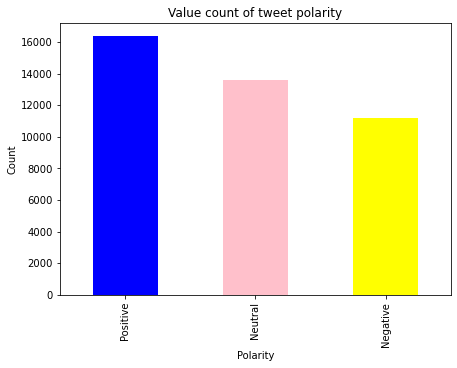

In [15]:
fig = plt.figure(figsize=(7,5))
color = ['blue','pink','yellow']
df['Analysis'].value_counts().plot(kind='bar',color = color)
plt.title('Value count of tweet polarity')
plt.ylabel('Count')
plt.xlabel('Polarity')
plt.grid(False)
plt.show()

Text(0.5, 1.0, 'Distribution of polarity')

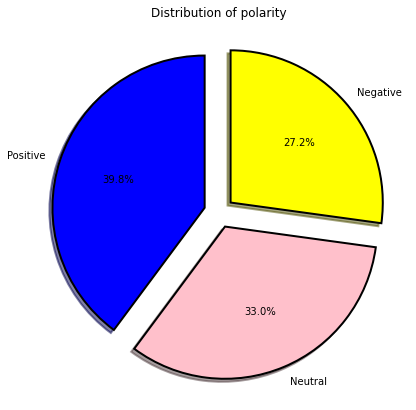

In [16]:
fig = plt.figure(figsize=(7,7))
colors = ('blue','pink','yellow')
wp={'linewidth':2, 'edgecolor': 'black'}
tags=df['Analysis'].value_counts()
explode = (0.1,0.1,0.1)
tags.plot(kind='pie', autopct='%1.1f%%', shadow=True, colors=colors, 
         startangle=90, wedgeprops=wp, explode=explode, label='')
plt.title('Distribution of polarity')

102
664
778
834
1068
1546
2113
2159
2195
2619
2794
2873
2957
3003
3305
3335
3373
3680
3716
3717
3752
3849
3860
3883
3941
3994
4558
4658
4920
4960
5050
5140
5154
5173
5174
5282
5298
5301
5310
5314
5318
5346
5384
5525
5845
5846
5847
6426
6533
6544
6578
6585
6691
7059
7218
7232
7252
7259
7401
7404
7456
8108
8324
8367
8633
8635
8660
8747
8845
8867
8974
8999
9114
9224
9306
9393
9448
9592
9593
9612
9748
10275
10300
10719
11020
11047
11203
11243
11585
11756
11776
11803
12219
12458
12459
12470
12740
12865
12958
13588
13695
13868
14507
14726
15043
15075
15375
15485
15525
15527
15560
15880
15959
16157
16264
16325
16565
16588
16709
16753
16754
16865
17320
18088
18446
18503
18578
18611
18651
18900
19239
19383
19478
19481
19486
19938
20134
20683
20714
20716
20719
20949
20995
21069
21211
21467
21512
21633
21834
21860
22611
22621
22636
22645
22855
22858
22905
23620
23714
23801
24117
24594
24675
24677
24760
25418
25537
25568
25623
25761
25837
25911
25966
26095
26195
26247
26298
26462
26517
26540
26577

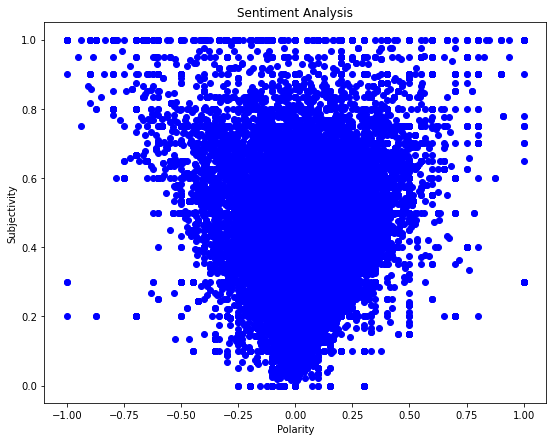

In [57]:
plt.figure(figsize=(9,7))
for i in range(0,df.shape[0]):
    try:
        plt.scatter(df['Polarity'][i],df['Subjectivity'][i], color='blue')
    except KeyError:
        print(i)
plt.title('Sentiment Analysis')
plt.xlabel('Polarity')
plt.ylabel('Subjectivity')
plt.show()

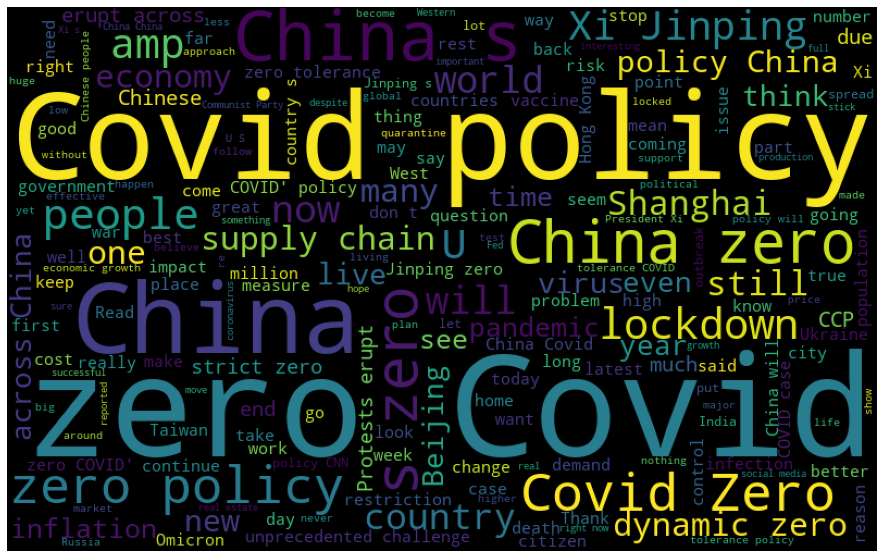

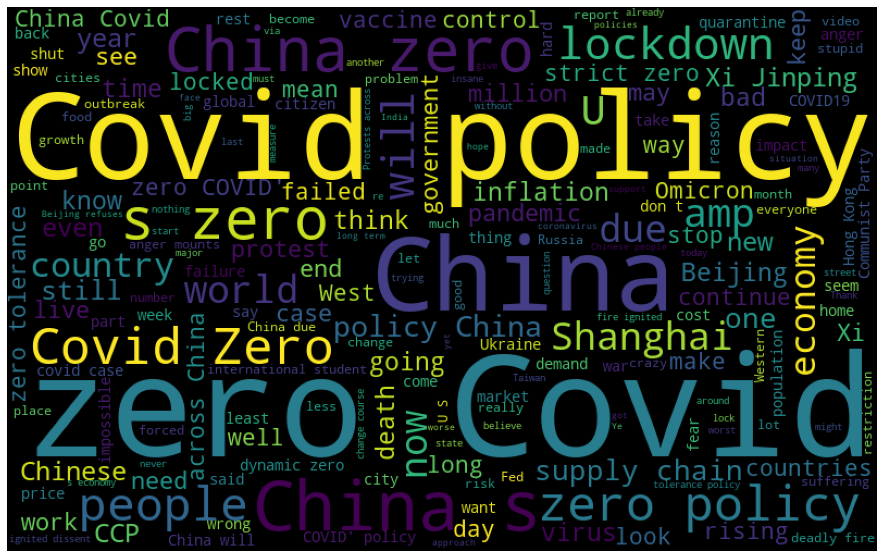

In [17]:
def create_wordcloud(text):    
    allWords = ' '.join([tweets for tweets in text])
    wordCloud = WordCloud(background_color='black', width=800, height=500, random_state=21, max_font_size=130).generate(allWords)
    plt.figure(figsize=(20,10))
    plt.imshow(wordCloud)
    plt.axis('off')
    plt.show()
#wordcloud for positive tweets
posTweets = df.loc[df['Analysis']=='Positive', 'cleanedTweets']
create_wordcloud(posTweets)
#wordcloud for negative tweets
negTweets = df.loc[df['Analysis']=='Negative', 'cleanedTweets']
create_wordcloud(negTweets)

## Lets turn the words into feature vectors so that we can analyze the numerical importance of certain word combinations

In [16]:
#Removing Punctuation
import string
def remove_punct(text):
 text = "".join([char for char in text if char not in string.punctuation])
 text = re.sub('[0–9]+', '', text)
 return text
df['punct'] = df['cleanedTweets'].apply(lambda x: remove_punct(x))
#Appliyng tokenization
def tokenization(text):
    text = re.split('\W+', text)
    return text
df['tokenized'] = df['punct'].apply(lambda x: tokenization(x.lower()))
#Removing stopwords
stopword = nltk.corpus.stopwords.words('english')
def remove_stopwords(text):
    text = [word for word in text if word not in stopword]
    return text
    
df['nonstop'] = df['tokenized'].apply(lambda x: remove_stopwords(x))
#Appliyng Stemmer
ps = nltk.PorterStemmer()
def stemming(text):
    text = [ps.stem(word) for word in text]
    return text
df['stemmed'] = df['nonstop'].apply(lambda x: stemming(x))
#Cleaning Text
def clean_text(text):
    text_lc = "".join([word.lower() for word in text if word not in string.punctuation]) # remove puntuation
    text_rc = re.sub('[0-9]+', '', text_lc)
    tokens = re.split('\W+', text_rc)    # tokenization
    text = [ps.stem(word) for word in tokens if word not in stopword]  # remove stopwords and stemming
    return text
df.head()

C:\Users\rahul\AppData\Local\Temp/ipykernel_7844/2030470429.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['punct'] = df['cleanedTweets'].apply(lambda x: remove_punct(x))


,cleanedTweets,Subjectivity,Polarity,Analysis,punct,tokenized,nonstop,stemmed
0,No exit from zero-COVID: China struggles to fi...,0.000000,0.000000,Neutral,No exit from zeroCOVID China struggles to find...,"[no, exit, from, zerocovid, china, struggles, ...","[exit, zerocovid, china, struggles, find, poli...","[exit, zerocovid, china, struggl, find, polici..."
1,Well at least we don't have China's zero covid...,0.400000,-0.300000,Negative,Well at least we dont have Chinas zero covid p...,"[well, at, least, we, dont, have, chinas, zero...","[well, least, dont, chinas, zero, covid, polic...","[well, least, dont, china, zero, covid, polici, ]"
2,No exit from zero-COVID: China struggles to fi...,0.000000,0.000000,Neutral,No exit from zeroCOVID China struggles to find...,"[no, exit, from, zerocovid, china, struggles, ...","[exit, zerocovid, china, struggles, find, poli...","[exit, zerocovid, china, struggl, find, polici..."
3,まじかー No exit from zero-COVID: China struggles...,0.000000,0.000000,Neutral,まじかー No exit from zeroCOVID China struggles t...,"[まじかー, no, exit, from, zerocovid, china, strug...","[まじかー, exit, zerocovid, china, struggles, find...","[まじかー, exit, zerocovid, china, struggl, find, ..."
4,"With Omicron, more and more Chinese scholars a...",0.436364,0.233766,Positive,With Omicron more and more Chinese scholars ar...,"[with, omicron, more, and, more, chinese, scho...","[omicron, chinese, scholars, starting, think, ...","[omicron, chines, scholar, start, think, new, ..."


In [18]:
from sklearn.feature_extraction.text import CountVectorizer
countVectorizer = CountVectorizer(analyzer=clean_text) 
countVector = countVectorizer.fit_transform(df['cleanedTweets'])
print('{} Number of tweets has {} words'.format(countVector.shape[0], countVector.shape[1]))
count_vect_df = pd.DataFrame(countVector.toarray(), columns=countVectorizer.get_feature_names())
count_vect_df

41122 Number of tweets has 24040 words


,,aa,aaa,aaaand,aag,aah,aaja,aajnewjdekhakya,aajtak,aal,...,𝗩𝗶𝗲𝘄𝘀,𝗬𝗼𝘂,𝘾𝙝𝙞𝙣𝙖,𝘿𝙤𝙡𝙡𝙖𝙧,𝙁𝙚𝙙,𝙖𝙣𝙙,𝙚𝙖𝙨𝙞𝙣𝙜,𝙥𝙖𝙪𝙨𝙞𝙣𝙜,𝙧𝙖𝙜𝙞𝙣𝙜,𝟲𝟬𝗦𝗲𝗰𝗼𝗻𝗱
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41117,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41118,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41119,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41120,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Analysis using N grams

In [20]:
def get_top_n_gram(corpus,ngram_range,n=None):
 vec = CountVectorizer(ngram_range=ngram_range,stop_words = 'english').fit(corpus)
 bag_of_words = vec.transform(corpus)
 sum_words = bag_of_words.sum(axis=0) 
 words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
 words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
 return words_freq[:n]
#n2_bigram
n2_bigrams = get_top_n_gram(df['cleanedTweets'],(2,2),20)
n2_bigrams

[('zero covid', 36727),
 ('covid policy', 34195),
 ('china zero', 14211),
 ('covid zero', 4195),
 ('zero policy', 4019),
 ('xi jinping', 2092),
 ('policy china', 2000),
 ('covid 19', 1863),
 ('china covid', 1667),
 ('dynamic zero', 1214),
 ('strict zero', 1038),
 ('supply chain', 1018),
 ('zero tolerance', 889),
 ('19 policy', 732),
 ('jinping zero', 694),
 ('supply chains', 619),
 ('china economy', 606),
 ('hong kong', 560),
 ('protests erupt', 544),
 ('erupt china', 527)]

In [21]:
n3_trigrams = get_top_n_gram(df['cleanedTweets'],(3,3),20)
n3_trigrams

[('zero covid policy', 33556),
 ('china zero covid', 13703),
 ('covid zero policy', 3715),
 ('covid policy china', 1586),
 ('china covid zero', 1182),
 ('dynamic zero covid', 1109),
 ('strict zero covid', 962),
 ('covid 19 policy', 731),
 ('xi jinping zero', 690),
 ('jinping zero covid', 686),
 ('zero covid 19', 588),
 ('protests erupt china', 522),
 ('challenge xi jinping', 454),
 ('unprecedented challenge xi', 450),
 ('china unprecedented challenge', 434),
 ('erupt china unprecedented', 431),
 ('zero tolerance covid', 418),
 ('china dynamic zero', 386),
 ('china strict zero', 385),
 ('zero tolerance policy', 364)]

## It can be seen that the policy has been a very strict enforcement and the policy has stirred protests and has challenged the government of china severely from N gram such as ('china unprecedented challenge', 434), ('erupt china unprecedented', 431), ('protests erupt china', 522),('challenge xi jinping', 454)  